# Benchmarks

In [236]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [229]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

In [230]:
data = (
    df
    .assign(
        mov_vs_spread = lambda x: x['mov'] + x['point_spread'],
        predicted_winner = lambda x: x['point_spread'].transform(lambda s: True if s < 0 else False),
        actual_winner = lambda x: x['mov'].transform(lambda s: True if s >0 else False),
        line_right = lambda x: x['predicted_winner'] == x['actual_winner'],
        train_test = lambda x: x['game_number'].transform(lambda s: 'Train' if s <= 20 else 'Test'),
        delta = lambda x: abs(x['mov_vs_spread']),
        delta_squared = lambda x: x['delta'] ** 2,
        Era = lambda x: x['season'].apply(lambda s: 'Pre 2016' if s < "2016-17" else 'Modern')
    )
    .query('home_away == "Home"')
)

data.sample(20)

,team,team_points,opponent,opponent_points,point_spread,file_name,game_id,season,dt,home_away,mov,game_number,mov_vs_spread,predicted_winner,actual_winner,line_right,train_test,delta,delta_squared,Era
26762,Charlotte,108,Atlanta,94,-12.0,nba odds 2018-19.xlsx,3412328bed7d58a8016969cc5b884db8,2018-19,2018-11-28,Home,14,21.0,2.0,True,True,True,Test,2.0,4.00,Modern
13270,Nets,90,Dallas,98,-3.0,nba odds 2012-13.xlsx,e9f26f83b949a6d865c4a716fdd91237,2012-13,2013-03-01,Home,-8,59.0,-11.0,True,False,False,Test,11.0,121.00,Pre 2016
8891,NewOrleans,103,GoldenState,110,-6.0,nba odds 2010-11.xlsx,904c076db69ef7f0ca6eb785574cf198,2010-11,2011-01-05,Home,-7,36.0,-13.0,True,False,False,Test,13.0,169.00,Pre 2016
21929,Chicago,69,Milwaukee,95,-5.5,nba odds 2016-17.xlsx,a0150c0b1d05c96c2675499007345789,2016-17,2016-12-16,Home,-26,26.0,-31.5,True,False,False,Test,31.5,992.25,Modern
2216,Toronto,95,Boston,98,-1.5,nba odds 2007-08.xlsx,b1fa5b936cb0b5444f9ae08cc5ceb3c4,2007-08,2007-11-04,Home,-3,3.0,-4.5,True,False,False,Train,4.5,20.25,Pre 2016
2158,Seattle,123,Toronto,115,5.0,nba odds 2007-08.xlsx,d335b75eed753b918968b77df25018d2,2007-08,2007-12-21,Home,8,27.0,13.0,False,True,False,Test,13.0,169.00,Pre 2016
21514,Utah,90,OklahomaCity,94,3.5,nba odds 2015-16.xlsx,483298e7784fb7c02b7a27933ccc370c,2015-16,2015-12-11,Home,-4,21.0,-0.5,False,False,True,Test,0.5,0.25,Pre 2016
1179,Miami,98,Milwaukee,103,-3.0,nba odds 2007-08.xlsx,20c22c658f3bcfdbd23493d6e943e987,2007-08,2008-01-02,Home,-5,32.0,-8.0,True,False,False,Test,8.0,64.00,Pre 2016
7482,Boston,105,Denver,89,-9.0,nba odds 2010-11.xlsx,3fea8d593eeae4599d35da2a246606eb,2010-11,2010-12-08,Home,16,21.0,7.0,True,True,True,Test,7.0,49.00,Pre 2016
24199,Atlanta,113,Philadelphia,121,10.0,nba odds 2017-18.xlsx,8a8ef0b6e51a51eb72fbb0b2d5503b08,2017-18,2018-04-10,Home,-8,82.0,2.0,False,False,True,Test,2.0,4.00,Modern


In [231]:
batting_average = (
    data
    .groupby(['Era', 'game_number', 'line_right'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['Era', 'line_right'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['Era', 'game_number'],
        columns='line_right',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['Era', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        BattingAverage = lambda x: 100 * x['correct'] / x['total']
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['Era', 'game_number', 'BattingAverage']]
)

mae = (
    data
    .groupby(['Era', 'game_number'])
    .agg(
        games = ('game_id', 'count'),
        total_delta = ('delta', 'sum'),
    )
    .reset_index()
    .assign(
        rolling_games = lambda x: x.groupby('Era')['games'].transform(lambda s: s.expanding().sum()),
        rolling_delta = lambda x: x.groupby('Era')['total_delta'].transform(lambda s: s.expanding().sum()),
        MAE = lambda x: x['rolling_delta'] / x['rolling_games'],
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['Era', 'game_number', 'MAE',]]
)

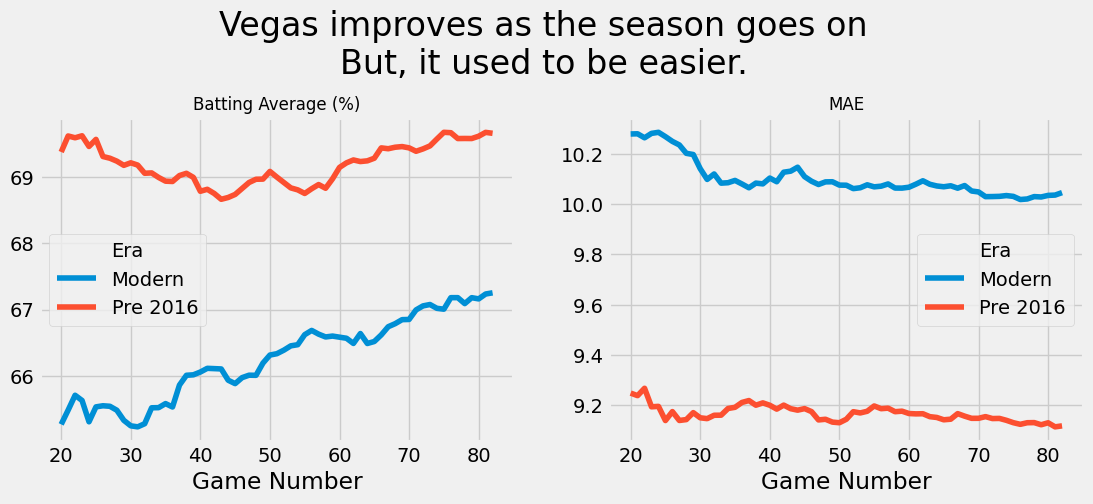

In [232]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

(
    batting_average
    .pivot_table(
        index='game_number',
        columns='Era',
        values='BattingAverage'
    )
    .plot(
        ax=ax1
    )
)

ax1.set_title('Batting Average (%)', size=12)
ax1.set_xlabel('Game Number')

(
    mae_and_rmse
    .pivot_table(
        index='game_number',
        columns='Era',
        values='MAE'
    )
    .plot(
        ax=ax2
    )
)

ax2.set_title('MAE', size=12)
ax2.set_xlabel('Game Number')


plt.suptitle('Vegas improves as the season goes on\nBut, it used to be easier.', size=24, y=1.15)
plt.show()

## MOV and the Spread

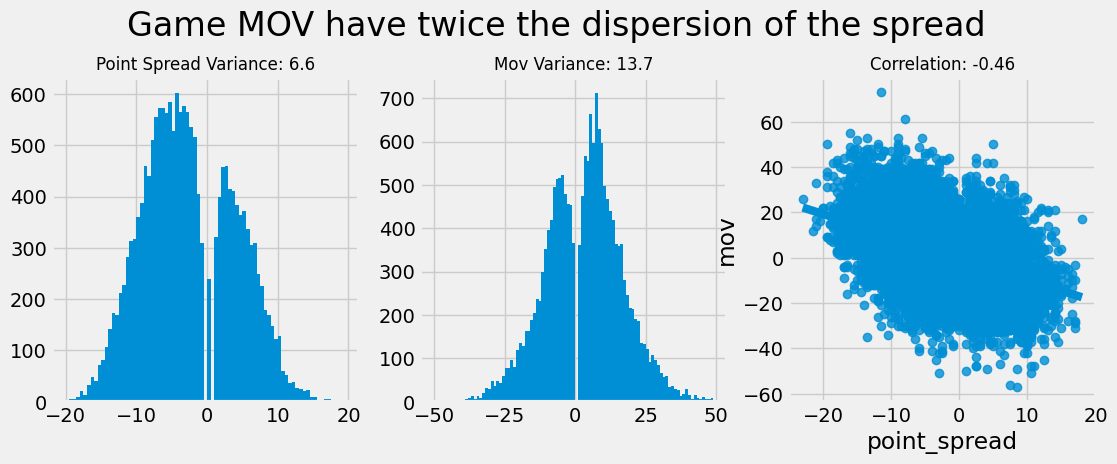

In [233]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

(
    data
    ['point_spread']
    .hist(
        ax=ax1,
        bins=np.arange(-20,20,0.5)
    )
)
 
(
    data
    ['mov']
    .hist(
        ax=ax2,
        bins=np.arange(-50,50,1)
    )
)

sns.regplot(
    data=data,
    x='point_spread',
    y='mov',
    ax=ax3
)


correlation = (
    data
    [['mov', 'point_spread']]
    .corr()
    .min()
    .min()
)

ax1.set_title(f'Point Spread Variance: {round(data.point_spread.std(),1)}', size=12)
ax2.set_title(f'Mov Variance: {round(data.mov.std(),1)}', size=12)
ax3.set_title(f'Correlation: {round(correlation, 2)}', size=12)

plt.suptitle('Game MOV have twice the dispersion of the spread', size=24, y=1.05)
plt.savefig('../images/benchmarks__mov_vs_spread.png', bbox_inches='tight')
plt.show()

## Point Spread vs MOV

In [255]:
seasons = data.season.unique().tolist()

vegas_benchmarks = []

for season in seasons:
    subset = (
        data
        .query(f'season == "{season}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
        [['game_id', 'mov', 'point_spread', 'line_right']]

    )
    
    X = subset['point_spread']
    y = subset['mov']

    model = sm.OLS(y, X)
    results = model.fit()
    
    row = {
        'season': season,
        'rsquared': results.rsquared,
        'batting_average': subset.line_right.mean()
    }
    
    vegas_benchmarks.append(row)

In [259]:
(
    pd.DataFrame(vegas_benchmarks)
    .melt(
        id_vars=['season'],
        var_name='feature_name',
        value_name='Vegas'
    )
    .to_csv(
        '../data/Vegas Benchmarks.csv',
        index=False
    )
)